### Neural network

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from PIL import Image

In [292]:
train_data = scio.loadmat("./ex4data1.mat")
X = train_data['X']
Y = train_data['y']

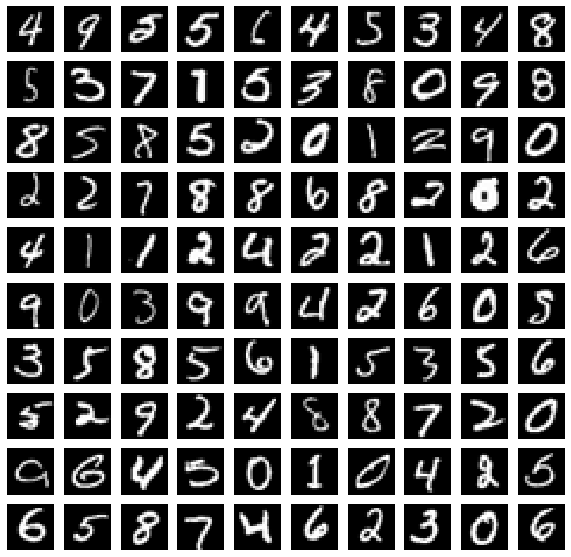

In [5]:
fig = plt.figure(figsize=(10, 10))  

data_to_show = np.random.permutation(X)[:100,:]
SIZE = 10
for i in range(0, SIZE):
    for j in range(0, SIZE):
        plt.subplot(SIZE, SIZE, i * SIZE + j + 1)
        # Must use order='F'(Fortant-like style)!!
        arr = data_to_show[i * SIZE + j].reshape((20, 20), order='F')
        arr = arr * 255
        img = Image.fromarray(arr)
        plt.imshow(img)
        plt.axis('off')
plt.show()

In [202]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

print(gradient(0))

def hypothesis(X, theta):
    return sigmoid(np.matmul(X, theta))

def compute_loss(H, Y):
    return np.sum(-Y * np.log(H) - (1 - Y) * np.log(1 - H)) / len(H)

def compute_loss_reg(H, Y, theta1, theta2, lamb=1):
    reg = lamb * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:] ** 2)) / (2 * len(H))
    return np.sum(-Y * np.log(H) - (1 - Y) * np.log(1 - H)) / len(H) + reg
  

0.25


In [294]:
weights = scio.loadmat("./ex4weights.mat")
theta1 = weights['Theta1']
print(theta1.shape)
theta2 = weights['Theta2']
print(theta2.shape)

def forward(X, theta1, theta2):
    data = np.c_[np.ones(len(X)), X]
    h = hypothesis(data, theta1.T)
    return hypothesis(np.c_[np.ones(len(h)), h], theta2.T)

output = forward(X, theta1, theta2)

num_classes = 10
y_expected = np.array([np.eye(num_classes, num_classes)[:,y - 1] for y in Y]).reshape(-1, num_classes)

loss = compute_loss(output, y_expected)
print('loss:', loss)

(25, 401)
(10, 26)
loss: 0.2876291651613189


In [170]:
loss = compute_loss_reg(output, y_expected, theta1, theta2, lamb=1)
print('loss:', loss)

loss: 0.38376985909092365


#### How does backpropagation work

loss function: 
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}log(a_k^{(i)}) - (1 - y_k^{(i)}log(1 - a_k^{(i)}]$$

where 
$$a = sigmoid(z) = g(z) = \frac{1}{1 + e^{-z}} $$

we know that
$$ g^{'}(z) = g(z)(1 - g(z)) $$

where 
$$ z^{(l + 1)} = (\theta^{(l)})^Ta^{(l)} = (\theta^{(l)})^Tg(z^{(l)}) $$

So, for the last layer, let 
$$ \delta^{(l + 1)} = \frac{\partial J}{\partial z^{(l + 1)}} = \frac{\partial J}{\partial a^{(l + 1)}}\cdot \frac{\partial a^{(l + 1)}}{\partial z^{(l + 1)}} = (-\frac{y^{(l + 1)}}{a^{(l + 1)}} + \frac{1 - y^{(l + 1)}}{1 - a^{(l + 1)}}) \cdot (a^{(l + 1)}(1 - a^{(l + 1)})) = a^{(l + 1)} - y^{(l + 1)} $$

then,
$$ \frac{\partial J}{\partial \theta^{(l)}} = \frac{\partial J}{\partial z^{(l + 1)}} \cdot \frac{\partial z^{(l + 1)}}{\partial a^{(l)}} = (a^{(l + 1)} - y^{(l + 1)})a^{(l)} $$

for previous layer,
$$ \delta^{(l)} = \frac{\partial J}{\partial z^{(l)}} = \frac{\partial J}{\partial z^{(l + 1)}} \cdot \frac{\partial z^{(l + 1)}}{\partial z^{(l)}} = \delta^{(l + 1)}(\theta^{(l)})^Tg^{'}(z^{(l)}) $$

then,
$$ \frac{\partial J}{\partial \theta^{(l - 1)}} = \frac{\partial J}{\partial z^{(l)}} \cdot \frac{\partial z^{(l)}}{\partial a^{(l - 1)}} = \delta^{(l)}a^{(l - 1)} $$


In [239]:
def backprop(X, Y, theta1, theta2):
    data = np.c_[np.ones(len(X)), X]
#     print(data.shape)
    h = hypothesis(data, theta1.T)
#     print(h.shape)
    a2 = np.c_[np.ones(len(h)), h]
    a3 = hypothesis(a2, theta2.T)
#     print(a3.shape)

    sigma3 = a3 - Y
#     print(sigma3.shape)
    delta2 = sigma3.T.dot(a2)
#     print(delta2.shape)
    sigma2 = sigma3.dot(theta2) * a2 * (1 - a2)
#     print(sigma2.shape)
    delta1 = sigma2.T.dot(data)
#     print(delta1.shape)

    gradient2 = delta2 / len(X)
    gradient1 = delta1[1:] / len(X)
    return gradient1, gradient2

gradient1, gradient2 = backprop(X, y_expected, theta1, theta2)
print(gradient1.shape, gradient2.shape)

(25, 401) (10, 26)


In [240]:
# Gradient checking
epsilon = 1e-4

def j_func(X, Y, theta1, theta2):
#     print(X.shape)
    output = forward(X, theta1, theta2)
    num_classes = 10
    expected = np.array([np.eye(num_classes, num_classes)[:,y - 1] for y in Y]).reshape(-1, num_classes)
    return compute_loss(output, expected)

theta1_plus = np.copy(theta1)
theta1_plus[0][3] += epsilon
theta1_minus = np.copy(theta1)
theta1_minus[0][3] -= epsilon
# print(theta1_plus)
# print(theta1_minus)
expected = (j_func(X, Y, theta1_plus, theta2) - j_func(X, Y, theta1_minus, theta2)) / (2 * epsilon)
gradient1, gradient2 = backprop(X, y_expected, theta1, theta2)

print(expected)
print(gradient1[0][3])
diff = np.linalg.norm(expected - gradient1[0][3]) / np.linalg.norm(expected + gradient1[0][3])

print(diff)

4.153066779366554e-09
4.153368916624279e-09
3.637387548435134e-05


In [248]:
def backprop_reg(X, Y, theta1, theta2, lamb=1):
    gradient1, gradient2 = backprop(X, Y, theta1, theta2)
    gradient1[:,1:] += (lamb / len(X)) * theta1[:,1:]
    gradient2[:,1:] += (lamb / len(X)) * theta2[:,1:]
    
    return gradient1, gradient2

gradient1, gradient2 = backprop_reg(X, y_expected, theta1, theta2)
print(gradient1.shape, gradient2.shape)


(25, 401) (10, 26)


In [242]:
# Gradient checking for regularized loss function
epsilon = 1e-4

def j_func(X, Y, theta1, theta2):
#     print(X.shape)
    output = forward(X, theta1, theta2)
    num_classes = 10
    expected = np.array([np.eye(num_classes, num_classes)[:,y - 1] for y in Y]).reshape(-1, num_classes)
    return compute_loss_reg(output, expected, theta1, theta2, lamb=1)

theta1_plus = np.copy(theta1)
theta1_plus[0][3] += epsilon
theta1_minus = np.copy(theta1)
theta1_minus[0][3] -= epsilon
# print(theta1_plus)
# print(theta1_minus)
expected = (j_func(X, Y, theta1_plus, theta2) - j_func(X, Y, theta1_minus, theta2)) / (2 * epsilon)
gradient1, gradient2 = backprop_reg(X, y_expected, theta1, theta2, lamb=1)

print(expected)
print(gradient1[0][3])
diff = np.linalg.norm(expected - gradient1[0][3]) / np.linalg.norm(expected + gradient1[0][3])

print(diff)

2.7688962234151404e-09
2.7689221984734294e-09
4.6904857310374205e-06


In [366]:
# Learning rate decade
min_lr = 0.001

def get_new_learning_rate(init_lr, epoch, max_epoch):
    # Cosine decade
    return min_lr + (init_lr - min_lr) * (1 + np.cos(epoch * np.pi / max_epoch))

# Training
# Mini-Batch SGD really help
epoch = 20000
theta1 = np.random.rand(theta1.shape[0], theta1.shape[1])
theta2 = np.random.rand(theta2.shape[0], theta2.shape[1])
print(theta1.shape, theta2.shape)
print(len(X))
init_lr = 0.6
lamb = 0.7
M = 500
for i in range(epoch):
    # SGD can improve performace
    indexes = np.random.permutation(range(0, len(X)))[:M]
    X_train = X[indexes]
    y_expected_train = y_expected[indexes]
    gradient1, gradient2 = backprop_reg(X_train, y_expected_train, theta1, theta2, lamb)
    # Learning rate decade
    learning_rate = get_new_learning_rate(init_lr, i, epoch)
    theta1 -= learning_rate * gradient1
    theta2 -= learning_rate * gradient2
    
    if i % 1000 == 0:
        output = forward(X_train, theta1, theta2)
        loss = compute_loss_reg(output, y_expected_train, theta1, theta2, lamb)
        print('loss:', loss)

(25, 401) (10, 26)
5000
loss: 17.272817077071323
loss: 2.555611836648478
loss: 0.9997355389554092
loss: 0.9216670717014366
loss: 0.8962780029229398
loss: 0.8518259298386337
loss: 0.8818622819512367
loss: 0.8918148969284561
loss: 0.87132510128856
loss: 0.8483575969690399
loss: 0.8498632087011121
loss: 0.8823616980706899
loss: 0.8675995080781325
loss: 0.8565411071165805
loss: 0.8659177489749523
loss: 0.8484899023110921
loss: 0.8222852237185843
loss: 0.8231935474163043
loss: 0.840811194402171
loss: 0.8275493949366285


In [367]:
# Testing
num_sample = len(X)

def get_accuracy(predicted, expected):
    return np.sum((predicted == expected).astype(int)) / num_sample

predicted = np.array([])
output = forward(X, theta1, theta2)
# print(output[:3])
for i in range(len(output)):
    max_y = 0
    max_accuracy = 0
    for j in range(len(output[i])):
        if output[i][j] > max_accuracy:
            max_accuracy = output[i][j]
            max_y = j + 1
    predicted = np.append(predicted, max_y)
print(get_accuracy(predicted, Y.ravel()))

0.949


(25, 20, 20)


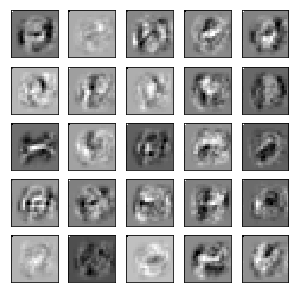

In [368]:
# Visualize the hidden layer

data_to_show = theta1[:,:-1].reshape(-1, 20, 20)
# print(data_to_show[0])
print(data_to_show.shape)
SIZE = np.sqrt(data_to_show.shape[0]).astype(int)
fig, ax_array = plt.subplots(SIZE, SIZE, sharey=True, sharex=True, figsize=(SIZE, SIZE))
for i in range(0, SIZE):
    for j in range(0, SIZE):
        arr = data_to_show[i * SIZE + j].reshape((20, 20))
        ax_array[i, j].matshow(arr, cmap=plt.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()